In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import constants 
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

#Import own function
from compute_alpha_hour import compute_alpha_hour

#Necesarry to load solution of ODE
from joblib import load




Load weather data

In [54]:
# specify the file path (use the actual path on your system)
file_path = 'Meteo_data/Weather_data_2023_7_6_n5.csv'

# read the CSV file into a DataFrame
df = pd.read_csv(file_path) #Data in seconds, T in K and P in Pa, windspeed in m/s, 0.1 meter above the ground

# Set time period
n_days = int(file_path[-5]) #Extract how many days are simulated in the file
df

,t,T_amb,P_amb,v_wind,P_sun
0,0.000000,286.400000,101450.0,1.033567,0.0
1,0.999991,286.400083,101450.0,1.033597,0.0
2,1.999981,286.400167,101450.0,1.033627,0.0
3,2.999972,286.400250,101450.0,1.033657,0.0
4,3.999963,286.400333,101450.0,1.033687,0.0
...,...,...,...,...,...
432000,431996.000037,290.300000,101760.0,1.033567,0.0
432001,431997.000028,290.300000,101760.0,1.033567,0.0
432002,431998.000019,290.300000,101760.0,1.033567,0.0
432003,431999.000009,290.300000,101760.0,1.033567,0.0


In [55]:
smoothing_factor=1
t=range(len(df['t']))
T_amb_spline = UnivariateSpline(df['t'], df['T_amb'], s=smoothing_factor)
P_amb_spline = UnivariateSpline(df['t'], df['P_amb'], s=smoothing_factor)


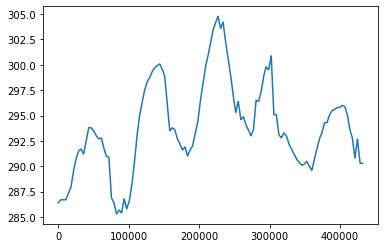

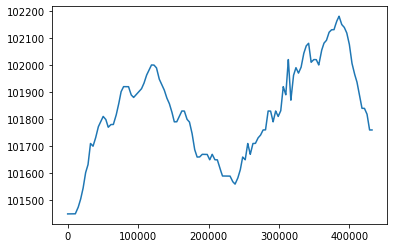

In [56]:
plt.plot(T_amb_spline(t))
plt.show()
plt.plot(P_amb_spline(t))
plt.show()


Simulation variables

In [57]:
#Vessel variables
#rho_vessel = 2.7e3 # aluminium [kg/m3]
rho_vessel = 1.455e3 # Pet [kg/m3] Source: https://plasticranger.com/density-of-pet-plastic/#:~:text=The%20density%20of%20PET%20plastic%20is%201.38%20g%2Fcm%C2%B3%20and,(1.2%20g%2Fcm3).
t_vessel = 0.5e-3 # Thickness [m]
#c_vessel = 890 #J/kg aluminium
c_vessel = 1030 #J/kg Pet Source: https://www.engineeringtoolbox.com/specific-heat-polymers-d_1862.html

#Assumptions
A_factor=0.5 #Assume half of the area of the vessel is exposed to sunlight 
e = 0.9 # emissvity factor black epoxy
alpha=100#[W/M^2K] Convection heat transfer coeficient
P_crit=1e3 #[pa] critical pressure where the hysterical valve opens
cloud_factor = np.linspace(0.1,1,2) # 1 = sunny, 0 = dark 


Simulation constants

In [58]:
#Vessel properties 
D = np.linspace(0.05,0.3,2) #Diameter vessel
L = np.linspace(0.05,0.3,2) #Lenght vessel

# Create a 2-D grid for D and L
D, L = np.meshgrid(D, L)

# Now D and L are 2-D arrays containing all combinations of diameter and length
V = D**2/4*np.pi*L  # [m^3]
A = D*L + D**2/4*np.pi  # [m^2]

#Air 
rho_air=1.293 #kgm-3 
m_air = rho_air*V #[kg]
R = constants.R #J/K*molz ideal gas constant 
c_air = 718 #j/kg K constant volume
n_mass = 28.96747 #molar mass [g/mol]
n = m_air/n_mass #Amount of mol air 
sigma = constants.sigma #Boltzman constant 

cp = 1000 #J/kgK @ 300 K
cv = 718 #J/kgK @ 300k
y = cp/cv 
K = 273.15 #Kelvin 

#Combined properties
m_vessel = A*t_vessel*rho_vessel
m = m_vessel+m_air #kg
c = m_vessel/m*c_vessel+m_air/m*c_air #j/kg K 

# Find the dimensions of A_exposed
num_rows, num_cols = A.shape
A_exposed= A_factor*A

# Create an array for each hour in the day, converted to seconds
dt=1 # Second
day_length = n_days*24 * 60 * 60  # length of a day in seconds
time_steps = np.linspace(0, day_length, num=day_length // dt + n_days)  # time steps
hours = np.arange(n_days*24)*60*60


Load old solution


In [59]:
#Load old solution
sol = load('..\\Saved_solutions\\2023_7_6_n5_20230811_174100_0_0_0_sol.joblib')
t=sol.t
y=sol.y

#Define solutions
T = y[0] # Temperature in pressure vessel
P = y[1] # Pressure in vessel
P_act = y[2] # Pressure in actuator 
n_mol = y[3] # Amount of mol in vessel 

In [60]:
#Set necesarry variables for plotting
ii=jj=ff=0
P_open=2e3
P_close =1e3

In [61]:
# Calculate solar constants
solar_constants_func = interp1d(np.arange(len(df['P_sun'].values)), df['P_sun'].values, bounds_error=False, fill_value="extrapolate")
interpolated_solar_constants = solar_constants_func(t)

#Interpolate the hourly wind data to convection per second
alpha_hour = compute_alpha_hour(num_rows, num_cols, D, df['v_wind'], time_steps, hours)

def interpolate_data(T, t, A_exposed, alpha_hour, T_amb,P_amb, ii, jj):
    # Interpolate T_amb
    #T_amb_func = interp1d(np.arange(len(T_amb)), T_amb, bounds_error=False, fill_value="extrapolate")
    #interpolated_T_amb = T_amb_func(t)
    interpolated_T_amb=T_amb_spline(t)
    

    #P_amb_func = interp1d(np.arange(len(P_amb)), P_amb, bounds_error=False, fill_value="extrapolate")
    #interpolated_P_amb = P_amb_func(t)
    interpolated_P_amb = P_amb_spline(t)
    
    # Interpolate alpha_hour
    alpha_interpolated_func = interp1d(np.arange(len(T_amb)), alpha_hour[ii,jj,:], bounds_error=False, fill_value="extrapolate")
    interpolated_alpha = alpha_interpolated_func(t)
    
    Q_rad = e * sigma * A_exposed[ii,jj] * (T**4 - interpolated_T_amb**4)
    Q_con = interpolated_alpha * A_exposed[ii,jj] * (T - interpolated_T_amb)
    return Q_rad, Q_con, interpolated_P_amb,interpolated_T_amb

#Eval function
#y1 = sol.sol(t)

Q_rad, Q_con,P_amb, T_amb = interpolate_data(y[0,:], t, A_exposed, alpha_hour, df['T_amb'].values,df['P_amb'].values, ii, jj)


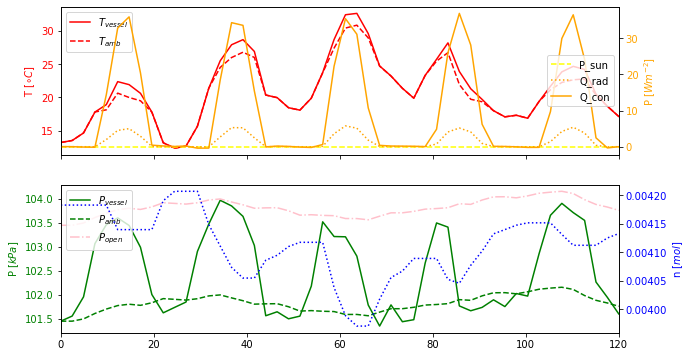

In [62]:
#Plot results 
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True,figsize=(10,6))  # Create two subplots sharing the same x-axis

# First subplot for temperature and solar constants
ax2 = ax1.twinx()  # Create a second y-axis for the first subplot
ax1.plot(t/3600, y[0,:]-K,color='red',label='$T_{vessel}$') 
ax1.plot(t/3600, T_amb_spline(t)-K,color='red', linestyle='--',label='$T_{amb}$') 
ax1.legend(loc='upper left')
ax1.set_ylabel('T [$\\circ C$]',color='red')
ax1.tick_params(axis='y', labelcolor='red')

#ax2.plot(t/3600, P_sun_spline(t), color='yellow',label='P_sun',linestyle='--')
ax2.plot(t/3600, df['P_sun'][0:len(t)], color='yellow',label='P_sun',linestyle='--')

ax2.plot(t/3600, Q_rad/A[ii,jj], label='Q_rad', linestyle=':', color='orange')
ax2.plot(t/3600, Q_con/A[ii,jj], label='Q_con', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylabel('P [$Wm^{-2}$]', color='orange')
ax2.legend()

# Second subplot for pressure and moles
ax4 = ax3.twinx()  # Create a second y-axis for the second subplot
ax3.plot(t/3600, y[1,:]/1000, color='green',label='$P_{vessel}$') 
#ax3.plot(t/3600, y[2,:]/1000, color='red',label='Act') 
ax3.plot(t/3600, P_amb_spline(t)/1000, color='green', linestyle='--',label='$P_{amb}$')
ax3.plot(t/3600, (y[2,:]+P_open)/1000, color='pink', linestyle='-.',label='$P_{open}$')
#ax3.plot(t/3600, (y[2,:]+P_close)/1000, color='pink', linestyle='-.',label='$P_{close}$')
#ax3.plot(t/3600, (P_amb-P_in)/1000, color='pink', linestyle='--',label='$P_{in}$')
ax3.set_ylabel('P [$kPa$]', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.legend(loc='upper left')

ax4.plot(t/3600, y[-1,:], color='blue',linestyle=':')  # Plot n_mol on the second y-axis
ax4.set_ylabel('n [$mol$]', color='blue')
ax4.tick_params(axis='y', labelcolor='blue')


plt.xlim(0,n_days*24)
#plt.savefig(f"..\\figures\\{file_path[-15:-4]}_{current_time}.svg", format="svg")
plt.show() 



In [63]:
#v_expelled[i]=v_expelled[i]+ ((n_mol[i-1]-n_mol[i])*R*T_amb_w[i] /P_amb[i])*1000

In [70]:
print(y[1,:])
len(t)

[101450.         101556.1993121  101957.09066588 103067.84529071
 103461.65437398 103603.37353101 103445.82142188 102990.27681576
 102004.91333544 101623.69369409 101737.16658491 101849.00505353
 102903.29323344 103475.57530747 103970.89799987 103852.77787081
 103635.61940891 103029.08944699 101562.81440423 101645.1667974
 101498.96730607 101554.87731993 102179.56957444 103521.50215099
 103214.74081439 103209.12338188 102805.82222238 101786.4129185
 101347.75354107 101789.09108169 101438.37324483 101480.7117372
 102661.91355584 103497.8091346  103410.94598621 101767.7265515
 101666.75472666 101737.20083017 101894.73542701 101754.10322326
 102026.33340936 101972.69439591 102855.20509871 103657.37006914
 103906.24056926 103713.94293644 103551.09680844 102265.83034595
 101945.50719202 101600.65436858]


50